In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from dark_emulator_public import dark_emulator
import os, sys, time, json, copy
import matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp2d, interp1d
from scipy.integrate import simps
from tqdm import tqdm
import hsc3x2pt

using dark_emulator at  /Users/sunao-mac/Documents/python_package/dark_emulator_public/dark_emulator/__init__.py


In [3]:
power_b1 = hsc3x2pt.power_b1_class()

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [5]:
dirname = './single_source_ClY1'
fisher2x2pt = hsc3x2pt.getFisher(dirname, power_b1, probes=['w', 'gamma_t'], 
                                 label='2x2pt (Y1, 1bin)', Omega_s={'gamma_t':Omega_s, 'xi':Omega_s})
fisherCS = hsc3x2pt.getFisher(dirname, power_b1, probes=['xi+','xi-'], 
                              label='Cosmic Shear (Y1, 1bin)', Omega_s={'gamma_t':Omega_s, 'xi':Omega_s})
fisher3x2pt = hsc3x2pt.getFisher(dirname, power_b1, 
                                 label='3x2pt (Y1, 1bin)', Omega_s={'gamma_t':Omega_s, 'xi':Omega_s})

fisher2x2ptPrior = fisher2x2pt.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm'], label='Prior')

fisher3x2ptPrior = fisher3x2pt.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm'], label='Prior')

fisherCSPrior = fisherCS.addPrior([0.00038, 0.0042, 0.1, 0.01], 
                                  ['omega_b', 'ns', 
                                   'dzph','dm'], label='Prior')

cov.shape = (66, 66), dim(data)=(66,)
cov.shape = (17, 17), dim(data)=(17,)
skip b1lowz because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass2 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamaglowz because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass2 because this is lens galaxy param, while probes does not include any lens related probe.
cov.shape = (83, 83), dim(data)=(83,)


In [6]:
dirname = './double_source_ClY1'
fisher2x2pt2 = hsc3x2pt.getFisher(dirname, power_b1, probes=['w', 'gamma_t'], 
                                 label='2x2pt (Y1, 2bins)', Omega_s={'gamma_t':Omega_s, 'xi':Omega_s})
fisherCS2 = hsc3x2pt.getFisher(dirname, power_b1, probes=['xi+','xi-'], 
                              label='Cosmic Shear (Y1, 2bins)', Omega_s={'gamma_t':Omega_s, 'xi':Omega_s})
fisher3x2pt2 = hsc3x2pt.getFisher(dirname, power_b1, 
                                 label='3x2pt (Y1, 2bins)', Omega_s={'gamma_t':Omega_s, 'xi':Omega_s})

fisher2x2pt2Prior = fisher2x2pt2.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm'], label='Prior')

fisher3x2pt2Prior = fisher3x2pt2.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm'], label='Prior')

fisherCS2Prior = fisherCS2.addPrior([0.00038, 0.0042, 0.1, 0.01], 
                                  ['omega_b', 'ns', 
                                   'dzph','dm'], label='Prior')

cov.shape = (90, 90), dim(data)=(90,)
cov.shape = (51, 51), dim(data)=(51,)
skip b1lowz because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass2 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamaglowz because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass2 because this is lens galaxy param, while probes does not include any lens related probe.
cov.shape = (141, 141), dim(data)=(141,)


In [7]:
dirname = './double_source_ClY1_2dm'
fisher2x2pt2_2dm = hsc3x2pt.getFisher(dirname, power_b1, probes=['w', 'gamma_t'], 
                                 label='2x2pt (Y1, 2bins)', Omega_s={'gamma_t':Omega_s, 'xi':Omega_s})
fisherCS2_2dm = hsc3x2pt.getFisher(dirname, power_b1, probes=['xi+','xi-'], 
                              label='Cosmic Shear (Y1, 2bins)', Omega_s={'gamma_t':Omega_s, 'xi':Omega_s})
fisher3x2pt2_2dm = hsc3x2pt.getFisher(dirname, power_b1, 
                                 label='3x2pt (Y1, 2bins)', Omega_s={'gamma_t':Omega_s, 'xi':Omega_s})

fisher2x2pt2Prior_2dm = fisher2x2pt2_2dm.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm1', 'dm2'], label='Prior')

fisher3x2pt2Prior_2dm = fisher3x2pt2_2dm.addPrior([0.00038, 0.0042, 0.5, 0.5, 0.5, 0.1, 0.01, 0.01], 
                                        ['omega_b', 'ns', 
                                         'alphamaglowz','alphamagcmass1','alphamagcmass2',
                                         'dzph','dm1', 'dm2'], label='Prior')

fisherCS2Prior_2dm = fisherCS2_2dm.addPrior([0.00038, 0.0042, 0.1, 0.01, 0.01], 
                                  ['omega_b', 'ns', 
                                   'dzph','dm1', 'dm2'], label='Prior')

cov.shape = (90, 90), dim(data)=(90,)
cov.shape = (51, 51), dim(data)=(51,)
skip b1lowz because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip b1cmass2 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamaglowz because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass1 because this is lens galaxy param, while probes does not include any lens related probe.
skip alphamagcmass2 because this is lens galaxy param, while probes does not include any lens related probe.
cov.shape = (141, 141), dim(data)=(141,)


In [8]:
corner = hsc3x2pt.corner_class()

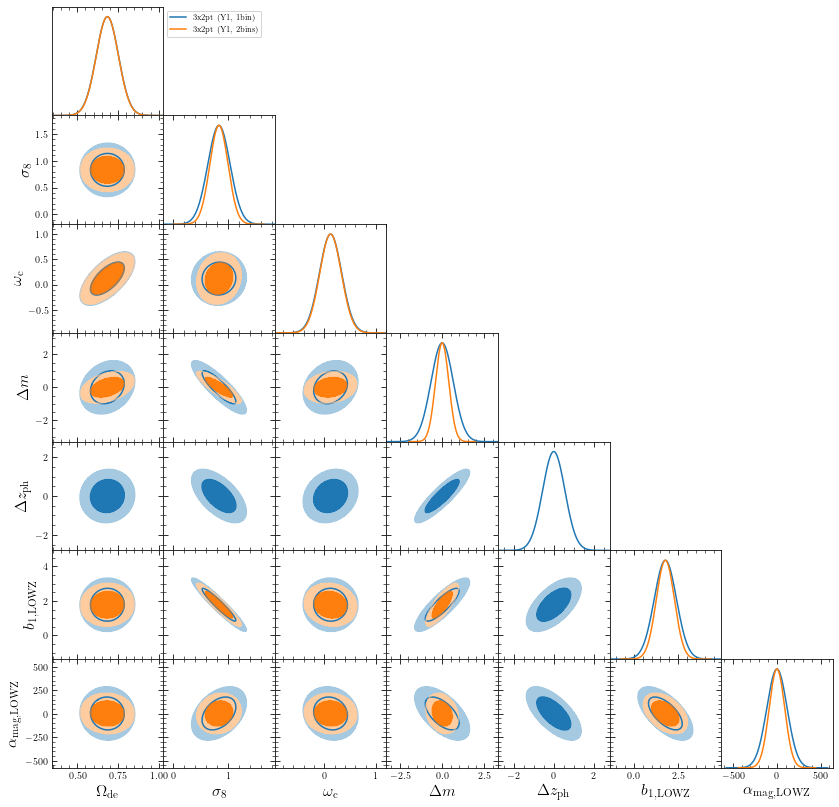

In [9]:
fig = corner.plot_corner([fisher3x2pt, fisher3x2pt2], 
                         ['Omega_de', 'sigma8', 'omega_c', 'dm', 'dzph', 'b1lowz', 'alphamaglowz'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_f3x2ptY1single_f3x2ptY1double.pdf')

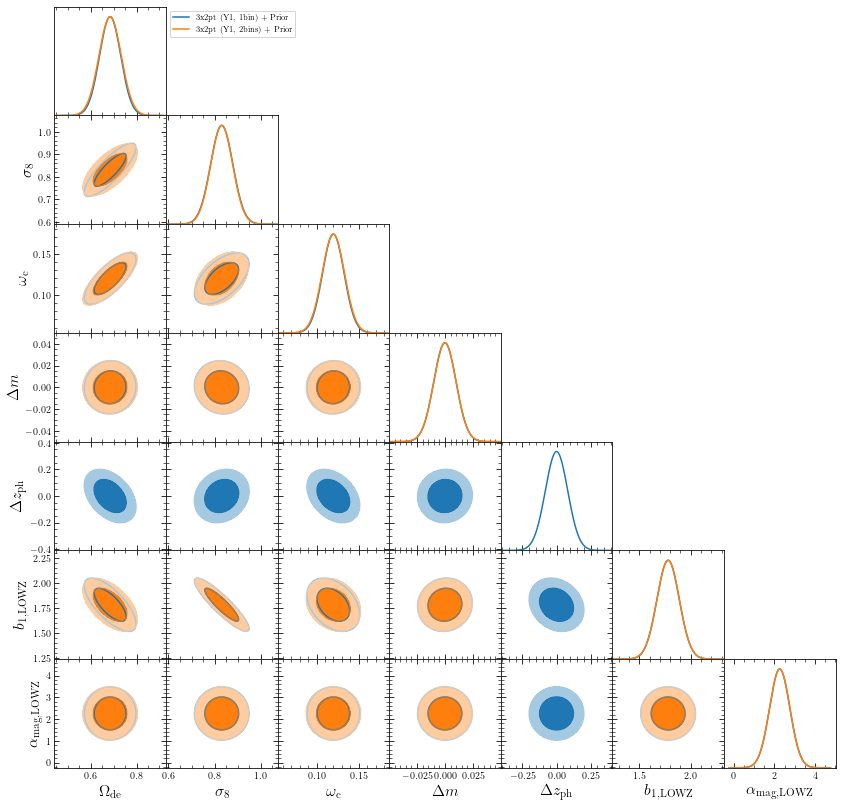

In [10]:
fig = corner.plot_corner([fisher3x2ptPrior, fisher3x2pt2Prior], 
                         ['Omega_de', 'sigma8', 'omega_c', 'dm', 'dzph', 'b1lowz', 'alphamaglowz'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_f3x2ptY1singlePrior_f3x2ptY1doublePrior.pdf')

dm1 is not included any fisher analysis. Omitting it.
dm2 is not included any fisher analysis. Omitting it.
dzph1 is not included any fisher analysis. Omitting it.
dzph2 is not included any fisher analysis. Omitting it.


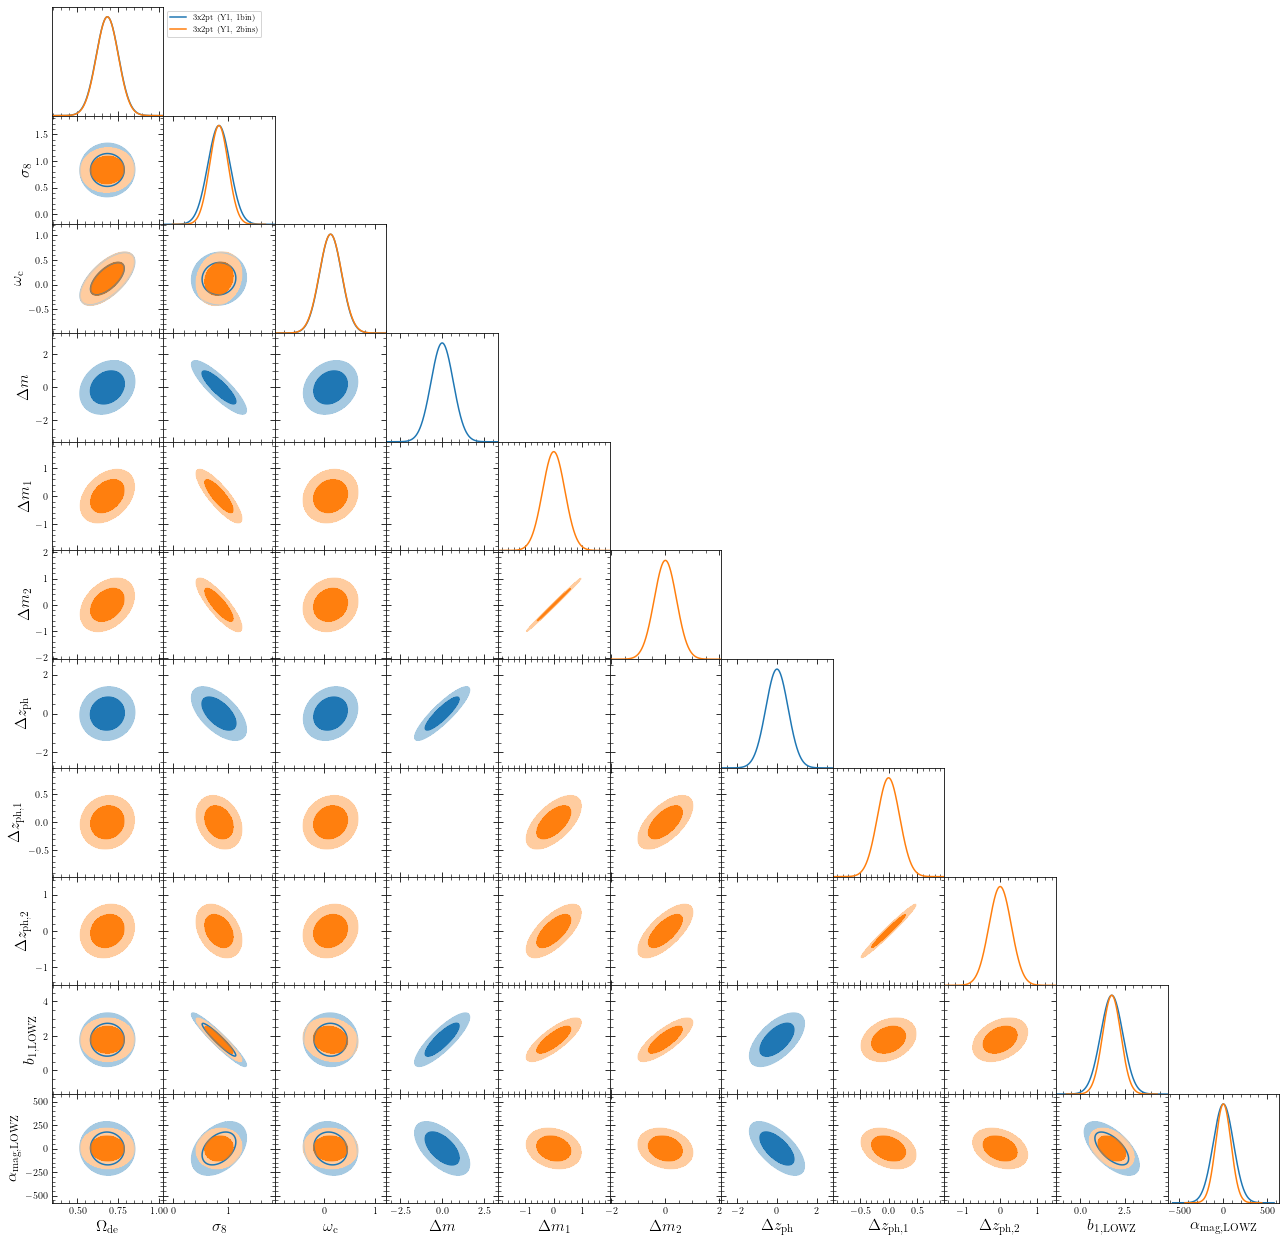

In [11]:
fig = corner.plot_corner([fisher3x2pt, fisher3x2pt2_2dm], 
                         ['Omega_de', 'sigma8', 'omega_c', 'dm', 'dm1', 'dm2', 'dzph', 'dzph1', 'dzph2', 'b1lowz', 'alphamaglowz'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_f3x2ptY1single_f3x2ptY1double2dm.pdf')

dm1 is not included any fisher analysis. Omitting it.
dm2 is not included any fisher analysis. Omitting it.
dzph1 is not included any fisher analysis. Omitting it.
dzph2 is not included any fisher analysis. Omitting it.


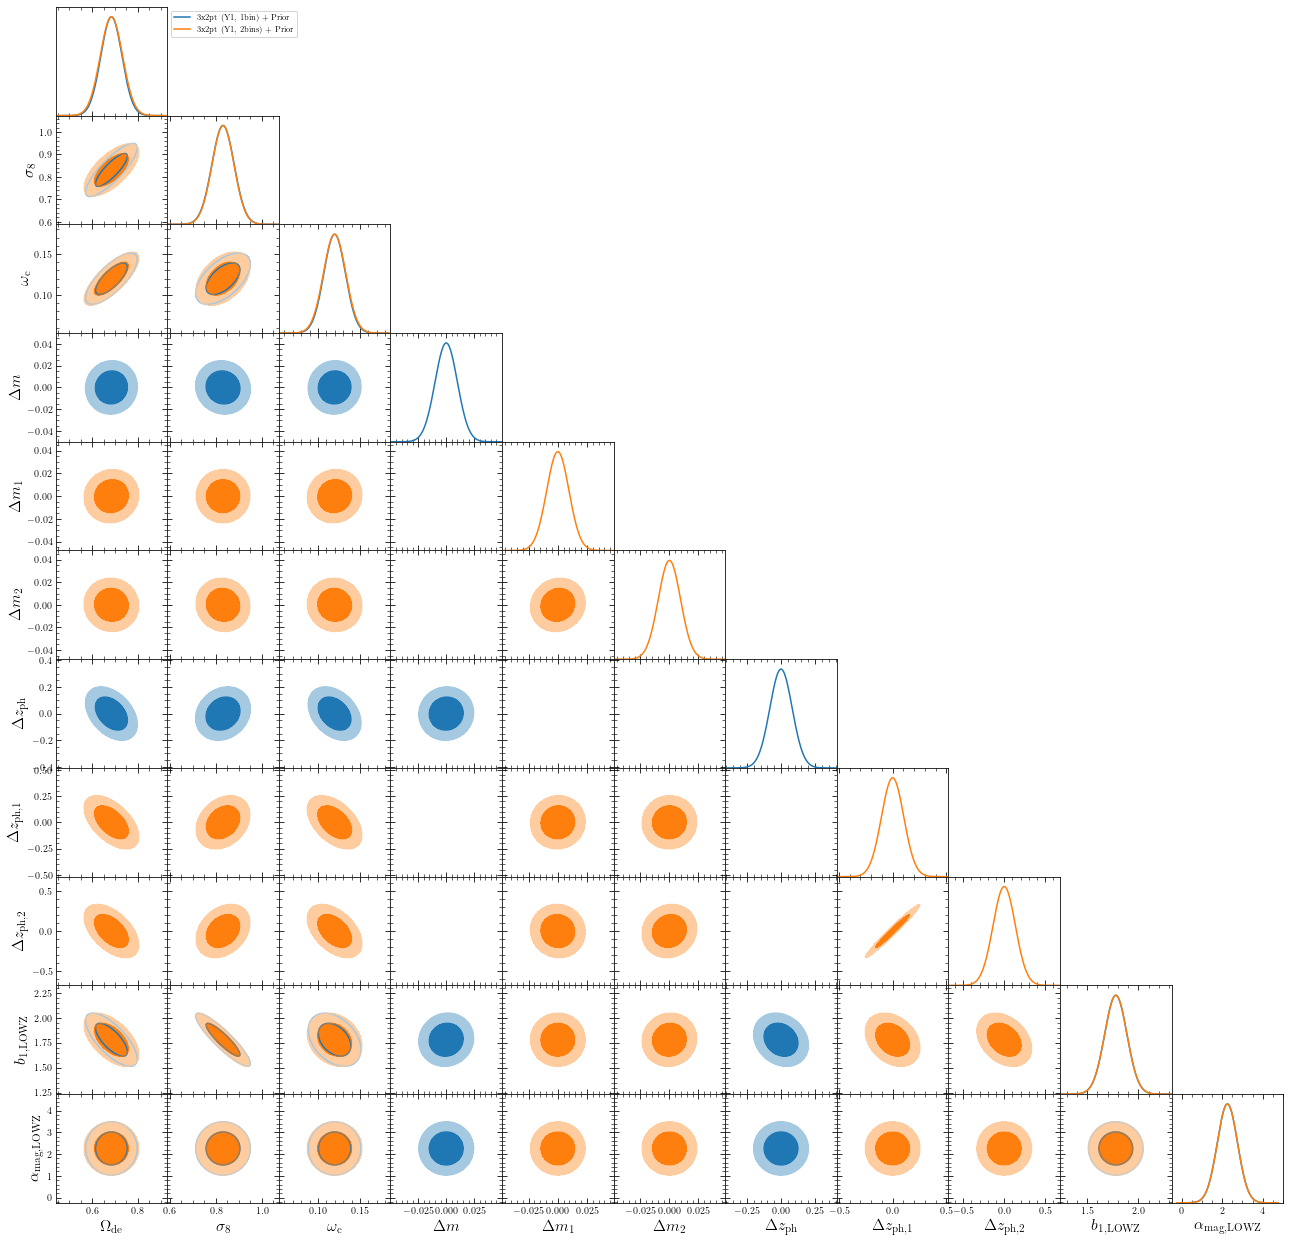

In [12]:
fig = corner.plot_corner([fisher3x2ptPrior, fisher3x2pt2Prior_2dm], 
                         ['Omega_de', 'sigma8', 'omega_c', 'dm', 'dm1', 'dm2', 'dzph', 'dzph1', 'dzph2', 'b1lowz', 'alphamaglowz'], 
                         figsize_ratio=2, usetex=True)
fig.export('figures/corner_f3x2ptY1singlePrior_f3x2ptY1doublePrior2dm.pdf')